In [2]:
%%configure 
{
    "script_location": "s3://shivam-trial-s3/code_artefacts/glue/scripts/",
    "--TempDir": "s3://shivam-trial-s3/code_artefacts/glue/temp/"
}

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 1.0.8 
The following configurations have been updated: {'script_location': 's3://shivam-trial-s3/code_artefacts/glue/scripts/', '--TempDir': 's3://shivam-trial-s3/code_artefacts/glue/temp/'}


In [1]:
%idle_timeout 15
%glue_version 4.0
%worker_type G.1X
%number_of_workers 2
import sys
from awsglue.transforms import *
from awsglue.utils import getResolvedOptions
from pyspark.context import SparkContext
from awsglue.context import GlueContext
from awsglue.job import Job
  
sc = SparkContext.getOrCreate()
glueContext = GlueContext(sc)
spark = glueContext.spark_session
job = Job(glueContext)

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
Installed kernel version: 1.0.8 
Current idle_timeout is None minutes.
idle_timeout has been set to 15 minutes.
Setting Glue version to: 4.0
Previous worker type: None
Setting new worker type to: G.1X
Previous number of workers: None
Setting new number of workers to: 2
Trying to create a Glue session for the kernel.
Session Type: glueetl
Worker Type: G.1X
Number of Workers: 2
Idle Timeout: 15
Session ID: 416338ba-9ea5-48fc-b4a3-bf611628a6fb
Applying the following default arguments:
--glue_kernel_version 1.0.8
--enable-glue-datacatalog true
Waiting for session 416338ba-9ea5-48fc-b4a3-bf611628a6fb to get into ready status...
Session 416338ba-9ea5-48fc-b4a3-bf611628a6fb has be

In [6]:
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql.types import *

import matplotlib.pyplot as plt

In [3]:
user_df = spark.sql("SELECT * FROM stage.stage_user")
content_df = spark.sql("SELECT * FROM stage.stage_content")
event_df = spark.sql("SELECT * FROM stage.stage_event")

In [4]:
# Calculate interaction metrics
interaction_metrics = event_df.groupBy("deviceid").pivot("eventname").count().fillna(0)
interaction_metrics.printSchema()
# interaction_metrics.show()

root
 |-- deviceid: string (nullable = true)
 |-- Back: long (nullable = true)
 |-- Front: long (nullable = true)
 |-- Opened: long (nullable = true)
 |-- Shared: long (nullable = true)
 |-- Shown: long (nullable = true)


In [6]:
# Aggregate language preference from content table
language_df = event_df.join(content_df.select("_id", "newsLanguage"), event_df.content_id == content_df._id, "left") \
                        .groupBy("deviceid", "newsLanguage").count().alias('count') \
                        .withColumn("rank", row_number().over(Window.partitionBy('deviceid').orderBy(col('count').desc()))) \
                        .filter(col("rank") == 1) \
                        .select("deviceid", col("newsLanguage").alias('preferred_language'))
# language_df.show()
language_df.printSchema()

root
 |-- deviceid: string (nullable = true)
 |-- preferred_language: string (nullable = true)


In [7]:
language_df.show()

+--------------------+------------------+
|            deviceid|preferred_language|
+--------------------+------------------+
|0001ca56-4fd5-449...|           english|
|000af0e8-4c57-455...|           english|
|00123c6e-50e0-431...|           english|
|00126e0d-0b9c-40c...|           english|
|001542e2-5802-433...|           english|
|0015d850-27a2-4f7...|           english|
|002124cc-5fff-4d1...|             hindi|
|00220c62-03a8-4c7...|           english|
|0024ab38-705a-4bc...|           english|
|0025d4e0-d32a-4e9...|           english|
|002664e8-356d-48b...|           english|
|002b0c0d-24e3-4e5...|           english|
|0034d8b8-9ccb-4e0...|           english|
|0035cff2-fa30-428...|           english|
|0036302b-af8e-4bb...|           english|
|0038e568-8d0e-41b...|           english|
|00397433-3bc6-49a...|           english|
|003a0597-6a5b-4fd...|           english|
|003b8ccf-c320-419...|             hindi|
|0041e280-2f6b-486...|           english|
+--------------------+------------

In [8]:
# Calculate engagement metrics
event_df_date = event_df.select('deviceid','content_id',to_date('eventtimestamp','yyyy-MM-dd').alias('event_date'),'timespent','eventname','batch_id')
engagement_df = event_df_date.groupBy("deviceid").agg(count("eventname").alias("total_interactions"), \
                        countDistinct("event_date").alias("active_days"),round(sum("timespent"),2).alias("total_timespent"))
# engagement_df.show()

In [9]:
engagement_df.printSchema()

root
 |-- deviceid: string (nullable = true)
 |-- total_interactions: long (nullable = false)
 |-- active_days: long (nullable = false)
 |-- total_timespent: double (nullable = true)


In [10]:
# Join interaction metrics with engagement metrics and language preference
user_engagement_df = interaction_metrics.join(engagement_df, "deviceid", "left").join(language_df, "deviceid", "left")
# user_engagement_df.show()

In [17]:
print(user_engagement_df.count())

42296


In [11]:
user_engagement_df.printSchema()

root
 |-- deviceid: string (nullable = true)
 |-- Back: long (nullable = true)
 |-- Front: long (nullable = true)
 |-- Opened: long (nullable = true)
 |-- Shared: long (nullable = true)
 |-- Shown: long (nullable = true)
 |-- total_interactions: long (nullable = true)
 |-- active_days: long (nullable = true)
 |-- total_timespent: double (nullable = true)
 |-- preferred_language: string (nullable = true)


+-------+------------------+
|summary|              Back|
+-------+------------------+
|  count|             42296|
|   mean|11.292344429733308|
| stddev| 43.14227615129945|
|    min|                 0|
|    max|              3089|
+-------+------------------+

Text(0.5, 1.0, 'Distribution of Column Values')



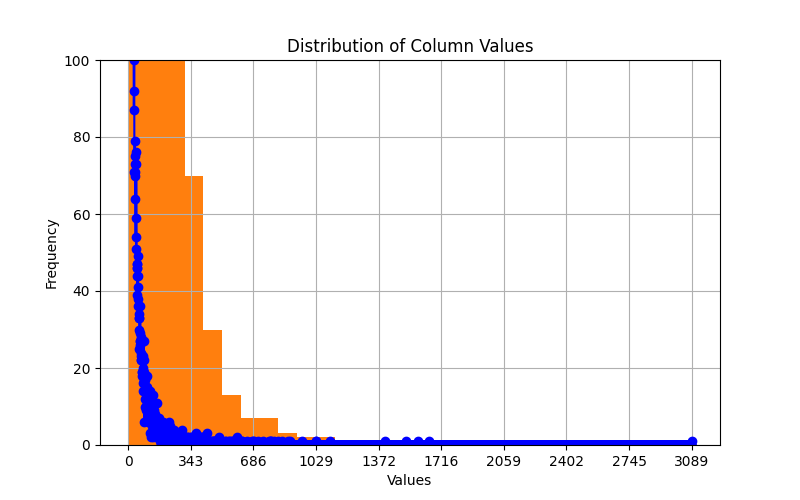

In [28]:
col = 'Back'

user_engagement_df.select(col).describe().show()

data = user_engagement_df.select(col).toPandas()
plt.hist(data[col], bins=30)
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.title("Distribution of Column Values")
%matplot plt

In [13]:
# User segmentation based on interaction and language patterns
segmented_df = user_engagement_df.withColumn("user_segment", \
    when((user_engagement_df.total_interactions > 1000) & (user_engagement_df.active_days > 30), concat(lit("Loyal Users - "), initcap(user_engagement_df.preferred_language))) \
    .when(user_engagement_df.Shared > 20, concat(lit("Social Sharers - "), initcap(user_engagement_df.preferred_language)))
    .when((user_engagement_df.Front + user_engagement_df.Back) > 5000, concat(lit("Content Readers - "), initcap(user_engagement_df.preferred_language))) \
    .when(user_engagement_df.Opened > 500, "Notification Engagers") \
    .when(user_engagement_df.total_interactions < 500, concat(lit("Occasional Users - "), initcap(user_engagement_df.preferred_language))) \
    .otherwise("Other"))

# Display the segmented users
# segmented_df.select("deviceid", "user_segment").show()

In [14]:
segmented_df.printSchema()

root
 |-- deviceid: string (nullable = true)
 |-- Back: long (nullable = true)
 |-- Front: long (nullable = true)
 |-- Opened: long (nullable = true)
 |-- Shared: long (nullable = true)
 |-- Shown: long (nullable = true)
 |-- total_interactions: long (nullable = true)
 |-- active_days: long (nullable = true)
 |-- total_timespent: double (nullable = true)
 |-- preferred_language: string (nullable = true)
 |-- user_segment: string (nullable = true)


In [17]:
df_unique = segmented_df.groupBy('user_segment').count().alias('count')
df_unique.show(truncate=False)

+--------------------------+-----+
|user_segment              |count|
+--------------------------+-----+
|Loyal Users - Hindi       |2395 |
|Occasional Users - Hindi  |3461 |
|Loyal Users - English     |14512|
|Other                     |4426 |
|Content Readers - English |29   |
|Occasional Users - English|17461|
|Social Sharers - English  |6    |
|Notification Engagers     |1    |
|Social Sharers - Hindi    |1    |
|Content Readers - Hindi   |4    |
+--------------------------+-----+


In [21]:
# aggregated_events = event_df.withColumn("event_date", to_date(event_df.eventtimestamp,'yyyy-MM-dd')) \
#     .groupBy("deviceid", "event_date").agg(max("event_date").alias("last_event_date"))
event_df_not_shown = event_df.filter(event_df.eventname != 'Shown')
aggregated_events = event_df_not_shown.withColumn("event_date", to_date(event_df_not_shown.eventtimestamp,'yyyy-MM-dd')).groupBy("deviceid").agg(max("event_date").alias("last_event_date"))
segmented_with_date_df = segmented_df.join(user_df.select("deviceid", "install_dt"), "deviceid", "left").join(aggregated_events, "deviceid", "left")
segmented_with_date_df = segmented_with_date_df.withColumn("days_since_install", datediff(segmented_with_date_df.last_event_date, segmented_with_date_df.install_dt))

# There are 18 vlaues where days_since_install is negative - removing them
segmented_with_date_df = segmented_with_date_df.filter(segmented_with_date_df.days_since_install >= 0)

inactive_user_df = segmented_with_date_df.withColumn("inactive_user_period", \
    when(col("days_since_install") == 0, "D1") \
    .when(col("days_since_install") == 1, "D2") \
    .when(col("days_since_install") < 7, "W1") \
    .when(col("days_since_install") < 30, "M1") \
    .when(col("days_since_install") < 90, "M3") \
    .otherwise("Other")
)

inactive_user_summary_df = inactive_user_df.groupBy("user_segment", "inactive_user_period").agg(countDistinct("deviceid").alias("inactive_user_count"))
# retention_summary = retention_summary.filter(retention_summary.retention_period != 'Other')

# retention_df.printSchema()
# retention_summary.printSchema()
# retention_df.show()

In [22]:
inactive_user_summary_df.printSchema()

root
 |-- user_segment: string (nullable = true)
 |-- inactive_user_period: string (nullable = false)
 |-- inactive_user_count: long (nullable = false)


In [37]:
#retention_summary.show(50,truncate=False)

+--------------------------+----------------+------------+
|user_segment              |retention_period|active_users|
+--------------------------+----------------+------------+
|Occasional Users - English|M3              |2786        |
|Loyal Users - Hindi       |M3              |866         |
|Occasional Users - Hindi  |D1              |1919        |
|Occasional Users - English|W1              |2215        |
|Other                     |D1              |112         |
|Content Readers - Hindi   |M1              |4           |
|Occasional Users - Hindi  |D2              |361         |
|Other                     |W1              |251         |
|Social Sharers - English  |M3              |2           |
|Other                     |D2              |40          |
|Occasional Users - English|D2              |1277        |
|Occasional Users - Hindi  |Other           |75          |
|Occasional Users - Hindi  |M1              |360         |
|Loyal Users - English     |Other           |10187      

In [23]:
total_user_segment_df = segmented_df.groupBy("user_segment").agg(countDistinct("deviceid").alias("total_users"))
total_user_segment_df.printSchema()

root
 |-- user_segment: string (nullable = true)
 |-- total_users: long (nullable = false)


In [26]:
inactive_user_agg_df = inactive_user_summary_df.join(total_user_segment_df, "user_segment", "left").withColumn("inactive_percentage", round((col("inactive_user_count") / col("total_users"))*100,2))
inactive_user_agg_df.printSchema()

root
 |-- user_segment: string (nullable = true)
 |-- inactive_user_period: string (nullable = false)
 |-- inactive_user_count: long (nullable = false)
 |-- total_users: long (nullable = true)
 |-- inactive_percentage: double (nullable = true)


In [54]:
#retention_smry.show(truncate=False)

+--------------------------+----------------+------------+-----------+--------------------+
|user_segment              |retention_period|active_users|total_users|retention_percentage|
+--------------------------+----------------+------------+-----------+--------------------+
|Loyal Users - Hindi       |M3              |866         |2395       |36.16               |
|Occasional Users - Hindi  |D1              |1920        |3461       |55.48               |
|Occasional Users - Hindi  |D2              |361         |3461       |10.43               |
|Occasional Users - Hindi  |M1              |360         |3461       |10.4                |
|Occasional Users - Hindi  |W1              |516         |3461       |14.91               |
|Loyal Users - Hindi       |D1              |10          |2395       |0.42                |
|Occasional Users - Hindi  |M3              |227         |3461       |6.56                |
|Other                     |D1              |112         |4426       |2.53      

In [29]:
# ordered_periods = ["M3", "M1", "W1", "D2", "D1"]

# # Add a numerical order column for correct sorting
# sorted_df = retention_smry.withColumn("period_order", \
#                 when(col("retention_period") == "D1", 5) \
#                 .when(col("retention_period") == "D2", 4) \
#                 .when(col("retention_period") == "W1", 3) \
#                 .when(col("retention_period") == "M1", 2) \
#                 .when(col("retention_period") == "M3", 1)) \
    # .orderBy("user_segment", "period_order", ascending=False)

# Calculate the cumulative retention rate in reverse order
inactive_user_pivot_df = inactive_user_agg_df.groupBy("user_segment").pivot("inactive_user_period").agg(first("inactive_percentage"))
segment_inactivity_time_metrics_df = inactive_user_pivot_df.na.fill(0)
# retention_cumulative = sorted_df.withColumn("cumulative_retention_rate", round(sum("retention_percentage").over(Window.partitionBy("user_segment").orderBy(col("period_order").asc())),2)).drop("period_order")

In [ ]:
# segment_inactivity_time_metrics

In [30]:
segment_inactivity_time_metrics_df.printSchema()

root
 |-- user_segment: string (nullable = true)
 |-- D1: double (nullable = false)
 |-- D2: double (nullable = false)
 |-- M1: double (nullable = false)
 |-- M3: double (nullable = false)
 |-- Other: double (nullable = false)
 |-- W1: double (nullable = false)


In [114]:
retention_cumulative_pivot.show(50,truncate=False)

+--------------------------+-----+-----+-----+-----+-----+-----+
|user_segment              |D1   |D2   |M1   |M3   |Other|W1   |
+--------------------------+-----+-----+-----+-----+-----+-----+
|Loyal Users - Hindi       |0.42 |0.04 |2.76 |36.16|60.29|0.29 |
|Occasional Users - Hindi  |55.48|10.43|10.4 |6.56 |2.17 |14.91|
|Notification Engagers     |0.0  |0.0  |100.0|0.0  |0.0  |0.0  |
|Other                     |2.53 |0.9  |46.02|27.95|16.83|5.67 |
|Content Readers - English |0.0  |0.0  |86.21|6.9  |6.9  |0.0  |
|Loyal Users - English     |0.3  |0.04 |1.45 |27.79|70.2 |0.19 |
|Social Sharers - English  |0.0  |0.0  |66.67|33.33|0.0  |0.0  |
|Occasional Users - English|43.39|7.31 |14.39|15.96|6.1  |12.69|
|Social Sharers - Hindi    |0.0  |0.0  |100.0|0.0  |0.0  |0.0  |
|Content Readers - Hindi   |0.0  |0.0  |100.0|0.0  |0.0  |0.0  |
+--------------------------+-----+-----+-----+-----+-----+-----+


In [35]:
retention_metrics = segment_inactivity_time_metrics_df.select('user_segment', \
    round((segment_inactivity_time_metrics_df.D1 + segment_inactivity_time_metrics_df.D2 + segment_inactivity_time_metrics_df.W1 + segment_inactivity_time_metrics_df.M1 + \
           segment_inactivity_time_metrics_df.M3 + segment_inactivity_time_metrics_df.Other),2).alias('D1'), \
    round((segment_inactivity_time_metrics_df.D2 + segment_inactivity_time_metrics_df.W1 + segment_inactivity_time_metrics_df.M1 + segment_inactivity_time_metrics_df.M3 + segment_inactivity_time_metrics_df.Other),2).alias('D2'), \
    round((segment_inactivity_time_metrics_df.W1 + segment_inactivity_time_metrics_df.M1 + segment_inactivity_time_metrics_df.M3 + segment_inactivity_time_metrics_df.Other),2).alias('W1'), \
    round((segment_inactivity_time_metrics_df.M1 + segment_inactivity_time_metrics_df.M3 + segment_inactivity_time_metrics_df.Other),2).alias('M1'), \
    round((segment_inactivity_time_metrics_df.M3 + segment_inactivity_time_metrics_df.Other),2).alias('M3') \
    )

retention_metrics.printSchema()

TypeError: Invalid argument, not a string or column: <generator object <genexpr> at 0x7f65d5d22650> of type <class 'generator'>. For column literals, use 'lit', 'array', 'struct' or 'create_map' function.


In [33]:
retention_metrics.show(50,truncate=False)

+--------------------------+------+------+------+------+-----+
|user_segment              |D1    |D2    |W1    |M1    |M3   |
+--------------------------+------+------+------+------+-----+
|Loyal Users - Hindi       |99.96 |99.54 |99.5  |99.21 |96.45|
|Occasional Users - Hindi  |99.95 |44.45 |34.0  |19.1  |8.73 |
|Social Sharers - Hindi    |100.0 |100.0 |100.0 |100.0 |0.0  |
|Notification Engagers     |100.0 |100.0 |100.0 |100.0 |0.0  |
|Social Sharers - English  |100.0 |100.0 |100.0 |100.0 |33.33|
|Occasional Users - English|99.84 |56.45 |49.14 |36.45 |22.06|
|Loyal Users - English     |99.97 |99.67 |99.63 |99.44 |97.99|
|Content Readers - English |100.01|100.01|100.01|100.01|13.8 |
|Other                     |99.9  |97.37 |96.47 |90.8  |44.78|
|Content Readers - Hindi   |100.0 |100.0 |100.0 |100.0 |0.0  |
+--------------------------+------+------+------+------+-----+


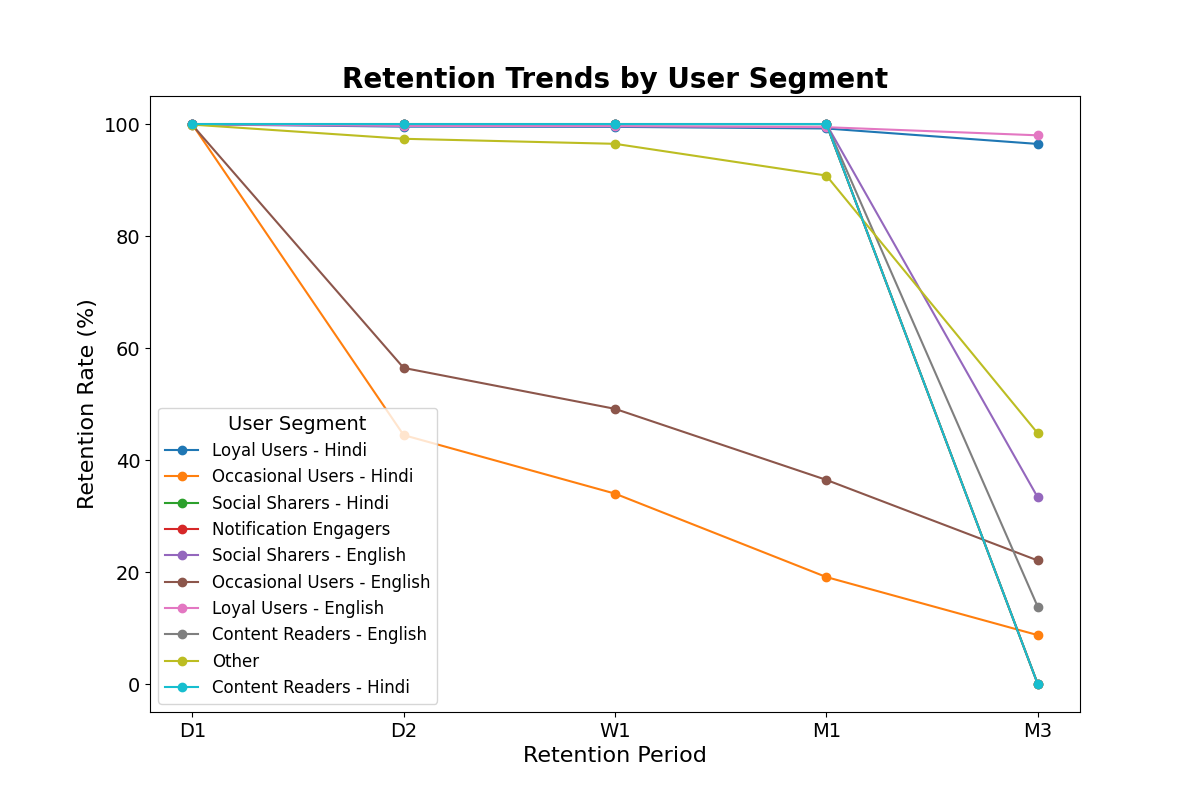

In [36]:
# Plotting retention metrics

retention_pd = retention_metrics.toPandas()

# Set the figure size
plt.figure(figsize=(12, 8))

# Plotting line plot for retention rates
for segment in retention_pd['user_segment'].unique():
    subset = retention_pd[retention_pd['user_segment'] == segment]
    plt.plot(['D1', 'D2', 'W1', 'M1', 'M3'], subset.iloc[0, 1:], marker='o', label=segment)

# Add title and labels
plt.title("Retention Trends by User Segment", fontsize=20, fontweight='bold')
plt.xlabel("Retention Period", fontsize=16)
plt.ylabel("Retention Rate (%)", fontsize=16)

# Customize x-axis and y-axis
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a legend
plt.legend(title="User Segment", fontsize=12, title_fontsize=14)
%matplot plt

In [38]:
churn_metrics = segment_inactivity_time_metrics_df.select('user_segment', \
    round((segment_inactivity_time_metrics_df.D1 ),2).alias('D1'), \
    round((segment_inactivity_time_metrics_df.D1 + segment_inactivity_time_metrics_df.D2),2).alias('D2'), \
    round((segment_inactivity_time_metrics_df.D1 + segment_inactivity_time_metrics_df.D2 + segment_inactivity_time_metrics_df.W1),2).alias('W1'), \
    round((segment_inactivity_time_metrics_df.D1 + segment_inactivity_time_metrics_df.D2 + segment_inactivity_time_metrics_df.W1 + segment_inactivity_time_metrics_df.M1),2).alias('M1'), \
    round((segment_inactivity_time_metrics_df.D1 + segment_inactivity_time_metrics_df.D2 + segment_inactivity_time_metrics_df.W1 + segment_inactivity_time_metrics_df.M1 + \
           segment_inactivity_time_metrics_df.M3),2).alias('M3') \
    )

churn_metrics.printSchema()

root
 |-- user_segment: string (nullable = true)
 |-- D1: double (nullable = true)
 |-- D2: double (nullable = true)
 |-- W1: double (nullable = true)
 |-- M1: double (nullable = true)
 |-- M3: double (nullable = true)


In [39]:
churn_metrics.show(50,truncate=False)

+--------------------------+-----+-----+-----+-----+-----+
|user_segment              |D1   |D2   |W1   |M1   |M3   |
+--------------------------+-----+-----+-----+-----+-----+
|Loyal Users - Hindi       |0.42 |0.46 |0.75 |3.51 |39.67|
|Occasional Users - Hindi  |55.5 |65.95|80.85|91.22|97.78|
|Social Sharers - Hindi    |0.0  |0.0  |0.0  |100.0|100.0|
|Notification Engagers     |0.0  |0.0  |0.0  |100.0|100.0|
|Social Sharers - English  |0.0  |0.0  |0.0  |66.67|100.0|
|Occasional Users - English|43.39|50.7 |63.39|77.78|93.74|
|Loyal Users - English     |0.3  |0.34 |0.53 |1.98 |29.77|
|Content Readers - English |0.0  |0.0  |0.0  |86.21|93.11|
|Other                     |2.53 |3.43 |9.1  |55.12|83.07|
|Content Readers - Hindi   |0.0  |0.0  |0.0  |100.0|100.0|
+--------------------------+-----+-----+-----+-----+-----+


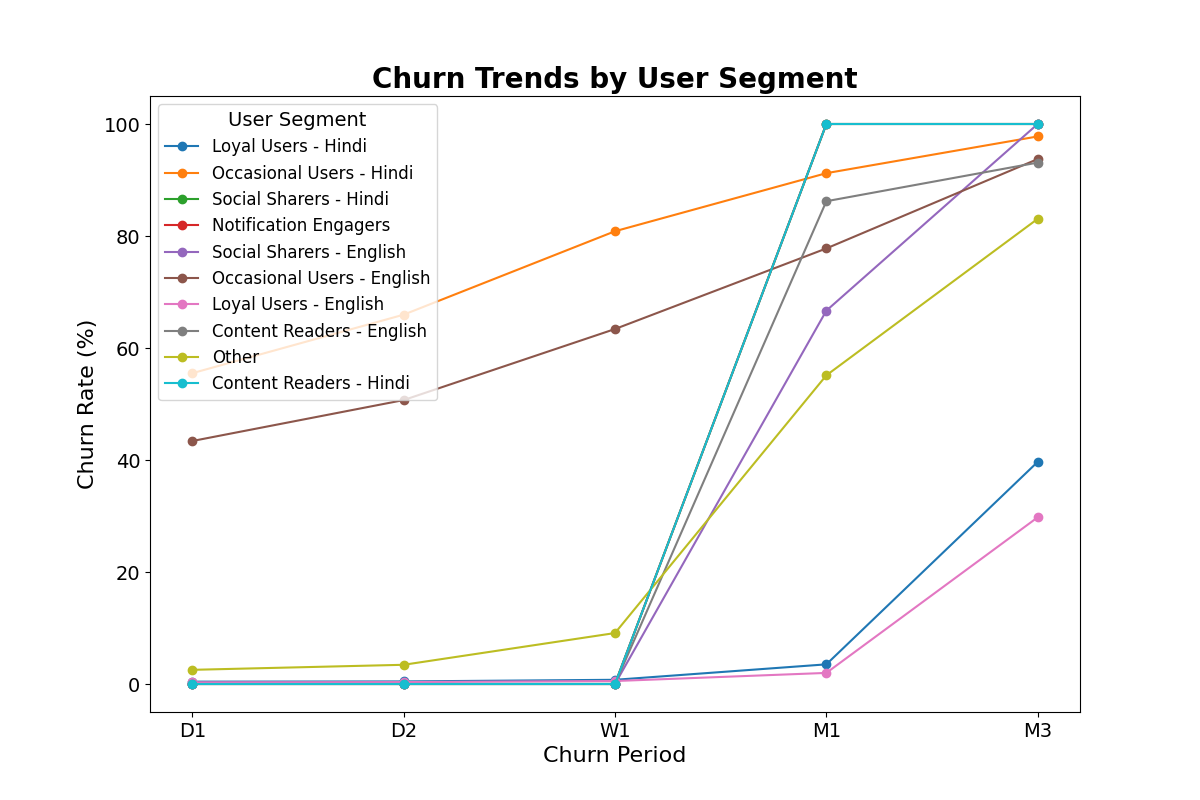

In [40]:
# Plotting churn metrics

churn_pd = churn_metrics.toPandas()

# Set the figure size
plt.figure(figsize=(12, 8))

# Plotting line plot for retention rates
for segment in churn_pd['user_segment'].unique():
    subset = churn_pd[churn_pd['user_segment'] == segment]
    plt.plot(['D1', 'D2', 'W1', 'M1', 'M3'], subset.iloc[0, 1:], marker='o', label=segment)

# Add title and labels
plt.title("Churn Trends by User Segment", fontsize=20, fontweight='bold')
plt.xlabel("Churn Period", fontsize=16)
plt.ylabel("Churn Rate (%)", fontsize=16)

# Customize x-axis and y-axis
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add a legend
plt.legend(title="User Segment", fontsize=12, title_fontsize=14)
%matplot plt